# Figures S6 and S7: inferred mouse assemblages
This script renders supplementary figures S6 and S7, giving all assemblages inferred on mouse data and those that are signficantly perturbed

### Before you start
This notebook assumes the analysis on the mouse dataset have been run and results are located in `MCSPACE_paper/results/analysis/Mouse`. Refer to the README in `scripts/analysis` for the analysis pipeline and more details.

In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset
from mcspace.utils import get_device, pickle_load, pickle_save,\
    estimate_process_variance, MODEL_FILE, DATA_FILE, \
    get_mcspace_cooccur_prob, get_sig_perturbation_diff_subset, \
    get_posterior_summary_data, get_pert_otu_sub, get_min_loss_path, apply_taxonomy_threshold, \
    get_summary_results
from mcspace import utils as ut
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# import mcspace.visualization as vis
from mcspace.dataset import DataSet
import pandas as pd

import ete3
from Bio import SeqIO, Phylo

import mcspace.vis_tools as vis
import matplotlib.colors as mcolors
import networkx as nx
import scipy.cluster.hierarchy as sch

In [2]:
# change font to Arial
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'

# Paths

Note: Paths are relative to this notebook, which is assumed to be located in `MCSPACE_paper/figures`

In [3]:
rootpath = Path("../../")
basepath = Path("./")

In [4]:
outpath = basepath / "paper_figures" / "supplemental"
outpath.mkdir(exist_ok=True, parents=True)

In [5]:
respath = rootpath / "MCSPACE_paper" / "results" / "analysis" / "Mouse" 
treepath = rootpath / "MCSPACE_paper" / "datasets" / "mouse_experiments" / "output" 
treefile = "newick_tree_query_reads.nhx"

# Load results

In [6]:
thetadf = pd.read_csv(respath / "assemblages.csv")
betadf = pd.read_csv(respath / "assemblage_proportions.csv", index_col=0)
pertsdf = pd.read_csv(respath / "perturbation_bayes_factors.csv", index_col=0)
radf= pd.read_csv(respath / "relative_abundances.csv", index_col=0)

In [7]:
taxlevels = ['Otu', 'Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
taxonomy = thetadf[taxlevels].copy()
taxonomy = taxonomy.set_index("Otu")
thetadf = thetadf.set_index(taxlevels)
radf.columns = radf.columns.astype(int)
avebeta = ut.get_subj_averaged_assemblage_proportions(betadf)

# Render figure S6

In [8]:
notus, ncomm = thetadf.shape

ntime_plot = 2
ncomm_max = 70
notu_max = 70

tree_ratio = 0.15
gap_ratio = 0.21

fontsize = 12
subfontsize = 10

tree_text_len = 120

theta_vmin=-2.0
theta_vmax=0

theta_cmap = mcolors.LinearSegmentedColormap.from_list('theta cmap', 
                                             [(0,'lightyellow'),
                                              (0.7, 'yellowgreen'),
                                              (1,    'green')], N=256)
theta_cmap.set_under('white')

theta_norm = norm = mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)

subjects = betadf['Subject'].unique()
times = betadf['Time'].unique()

nsubj = len(subjects)
ntime = len(times)

diet_colors = ['black', 'blue', 'black', 'yellow', 'black', 'red', 'black']
diets = ['S1', 'HF', 'S2', 'HFHF', 'S3', 'LP', 'S4']

In [9]:
# filter using 5% threshold
otu_threshold = 0.05
otu_sub = thetadf.index[(thetadf>otu_threshold).any(axis=1)].get_level_values("Otu")

original tree size: 1406
pruned tree size: 53


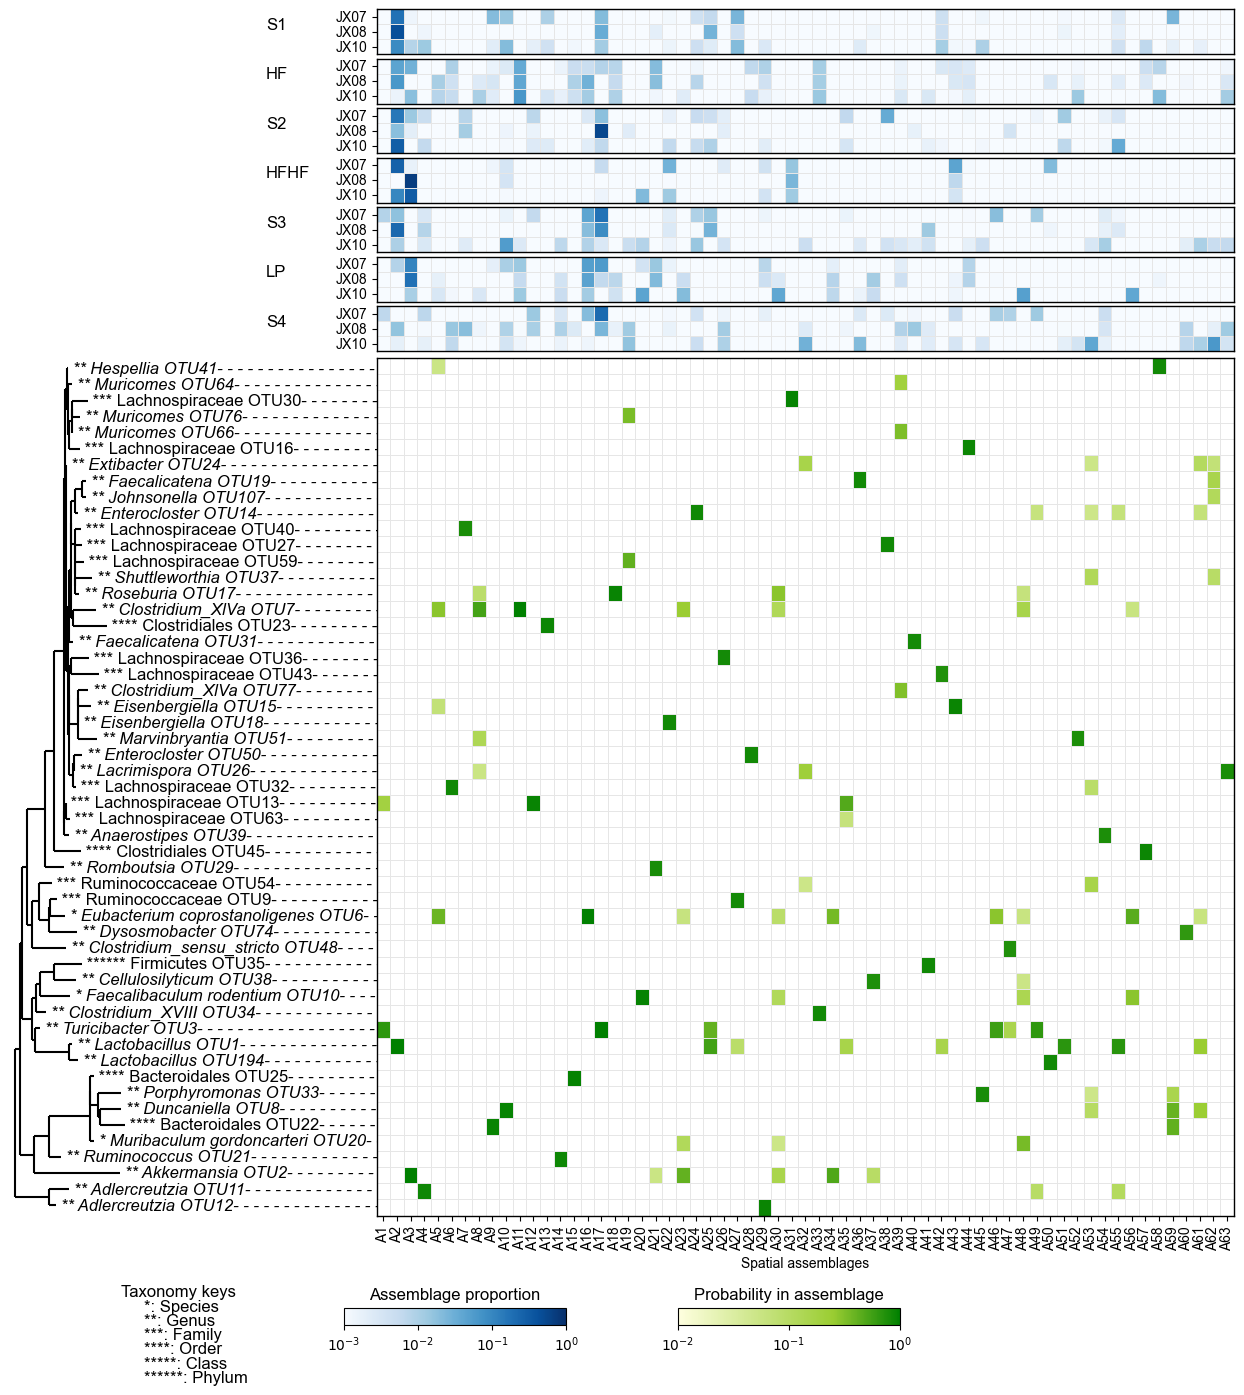

In [10]:
scale=1.5

lgd_ratio = 0.07
lgd_gap = 0.1

# set aspect ratios
# add buffers so scales always same?
hratios = [1.3*nsubj/notu_max]*ntime
hratios.append(notus/notu_max)
hratios.append(lgd_gap)
hratios.append(lgd_ratio)
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max) - lgd_ratio - lgd_gap) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,0.7*11.5*scale))
gs = fig.add_gridspec(nrows=ntime+2+2,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.05,
                     hspace=0.05)

# create subplots, get axes
ax_betas = []
for i in range(ntime):
    ax_betas.append(fig.add_subplot(gs[i,2]))
ax_tree = fig.add_subplot(gs[-4,0])

squish_ratio = 0.003
squish_hspace = 0

# create subplots, get axes
gs_theta = gs[-4,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_theta = fig.add_subplot(gs_theta[1,0])
    
# ax_theta = fig.add_subplot(gs[-4,2])

# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,4, wspace=0.5)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_beta_lgd = fig.add_subplot(gs_lgd[0,1])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,2])
    
    
# plot assemlage proportions
beta_order = thetadf.columns #vis.get_abundance_order(betadf)

for i,t in enumerate(times):
    ax_betas[i]=vis.plot_all_subject_proportions_at_timepoint(ax_betas[i], betadf, t, order=beta_order, vmin=-2)
    ax_betas[i].set_xticks([])
    ax_betas[i].set_yticklabels(ax_betas[i].get_yticklabels(), rotation=0, fontsize=subfontsize)
    ax_betas[i].set_ylabel(f"{diets[i]}", rotation=0, labelpad=50, ha = 'left', fontsize=fontsize)
    ax_betas[i].set_xlabel("")
    ax_betas[i] = vis.add_border(ax_betas[i]) #, color=diet_colors[i])
    
    
# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
# taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
taxa = taxa.set_index("Otu")
taxa_subset = taxa.loc[otu_sub,:]
tree = vis.get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize)

# plot assemblages
thetadf2 = thetadf.copy()
thetadf2[thetadf2<otu_threshold] = 0
ax_theta=vis.plot_assemblages(ax_theta, thetadf2, otu_order, beta_order, cmap=theta_cmap,
                                     vmin=theta_vmin, vmax=theta_vmax) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xlabel("Spatial assemblages", fontsize=subfontsize)
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = vis.add_border(ax_theta)

# plot legend
norm = theta_norm #mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Probability in assemblage")

norm = mpl.colors.Normalize(vmin=-3, vmax=-0)
ax_beta_lgd=mpl.colorbar.ColorbarBase(ax_beta_lgd, cmap="Blues", norm=norm, orientation='horizontal')
ax_beta_lgd.ax.set_xticks([0,-1,-2,-3])
ax_beta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$',r'$10^{-3}$'])
ax_beta_lgd.ax.set_title("Assemblage proportion")


lgd_xpos=0.5
lgd_ypos=1.2
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', ] #'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***',
              'Order': '****', 'Class': '*****', 'Phylum': '******'} #, 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

plt.savefig(outpath / "figure_S6_mouse_assemblages.svg",bbox_inches="tight")

# Render perturbed assemblages

In [11]:
def get_perturbed_assemblages(pertsdf, pnames=None, bf_threshold=10):
    cols = pertsdf.columns
    perturbed_assemblages = {}
    for i,c in enumerate(cols):
        if pnames is not None:
            key = pnames[i]
        else:
            key = c
        perturbed_assemblages[key] = pertsdf.index[pertsdf.loc[:,c]>=bf_threshold]
    return perturbed_assemblages


def plot_pert_beta_and_reference(ax, betamat, times, order, logscale=True, vmin=-3, vmax=0, cmap='Blues',
                                   linecolor ='#e6e6e6', linewidth=0.5, xticklabels=False, yticklabels=True,
                                   square=False, cbar=False):
    if logscale is True:
        betamatrix = np.log10(betamat)
    else:
        betamatrix = betamat
        
    ax=sns.heatmap(betamatrix.loc[times,order], ax=ax, cmap=cmap, square=square, vmin=vmin, vmax=vmax, cbar=cbar,
               linewidth=linewidth, linecolor=linecolor, xticklabels=xticklabels, yticklabels=yticklabels)
    return ax

In [12]:
pnames = ['HF', 'HFHF', 'LP']
perturbed_assemblages = get_perturbed_assemblages(pertsdf, pnames=pnames)

### cluster collumns

In [13]:
ptimes = [[10,18], [35,43], [57,65]]
dnames = [['S1','HF'], ['S2', 'HFHF'], ['S3', 'LP']]

all_assemblages = set([]) #list(set(nonsingleton_perturbed['HF'])
for p in pnames:
    all_assemblages = all_assemblages.union(set(perturbed_assemblages[p]))
all_assemblages = list(all_assemblages)

ncomm = len(all_assemblages)

# filter otus below 1%
otu_threshold = 0.05
otu_sub = thetadf.index[(thetadf.loc[:,all_assemblages]>otu_threshold).any(axis=1)].get_level_values('Otu')
notus = len(otu_sub)


# cluster columns
perturbed_clustered = {}
for p in pnames:
    temp = perturbed_assemblages[p].copy()
    if len(temp) > 1:
        thetadf2 = thetadf.copy()
        thetadf2[thetadf2<otu_threshold] = 0
        theta_plot = np.log10(thetadf2.loc[otu_sub,temp] + 1e-20)
        
        col_dist = sch.linkage(theta_plot.values.T, method='ward')
        col_order = sch.leaves_list(col_dist)
        comm_order = np.array(temp)[col_order]
        perturbed_clustered[p] = comm_order
    else:
        perturbed_clustered[p] = np.array(temp)

## Plot figure

In [14]:
ntime_plot = 2
ncomm_max = 40
notu_max = 50

tree_ratio = 0.15
gap_ratio = 0.2

fontsize = 12
subfontsize = 12

tree_text_len = 50

theta_vmin=-2.0
theta_vmax=0

theta_cmap = mcolors.LinearSegmentedColormap.from_list('theta cmap', 
                                             [(0,'lightyellow'),
                                              (0.7, 'yellowgreen'),
                                              (1,    'green')], N=256)
theta_cmap.set_under('white')

theta_norm = norm = mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)

original tree size: 1406
pruned tree size: 16


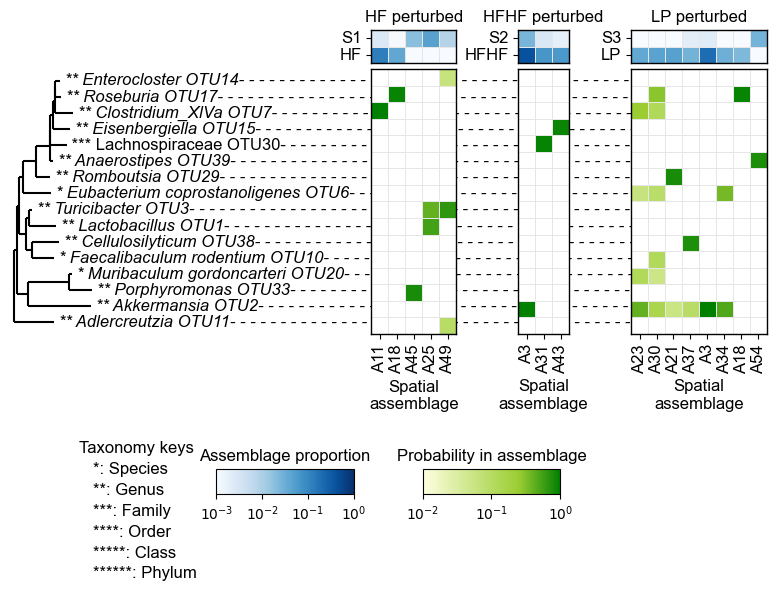

In [19]:
scale=1.5

# set aspect ratios
# add buffers so scales always same?
lgd_ratio = 0.1
lgd_gap = 0.15

hratios = [ntime_plot/notu_max, notus/notu_max, lgd_gap, lgd_ratio]
hratios.append(1.0 - (ntime_plot/notu_max) - (notus/notu_max)) # buffer?
wratios = [tree_ratio, gap_ratio]

total = tree_ratio + gap_ratio
for p in pnames:
    wid = len(perturbed_assemblages[p])/ncomm_max
    wratios.append(wid)
    total += wid
wratios.append(1.0 - total)

# create figure
fig = plt.figure(figsize=(8.5*scale,0.8*11.5*scale))
gs = fig.add_gridspec(nrows=1+2+2,ncols=3 + len(pnames),
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.55,
                     hspace=0.02)

# squish for centering tree
squish_ratio = 0.005
squish_hspace = 0

# create subplots, get axes
ax_betas = []
ax_tree = fig.add_subplot(gs[1,0])
gs_thetas = []
ax_thetas = []
for i in range(len(pnames)):
    ax_betas.append(fig.add_subplot(gs[0,2+i]))
    
    gs_thetas.append(gs[1,2+i].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace))
    ax_thetas.append(fig.add_subplot(gs_thetas[i][1,0]))

# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,4, wspace=0.5)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_beta_lgd = fig.add_subplot(gs_lgd[0,1])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,2])
    
    
# plot assemblage proportions
ttls = ['HF perturbed', 'HFHF perturbed', 'LP perturbed']
for i,p in enumerate(pnames):
    ax_betas[i] = plot_pert_beta_and_reference(ax_betas[i], avebeta, ptimes[i], perturbed_clustered[p])
    ax_betas[i].set_ylabel("")
    ax_betas[i].set_xlabel("")
    ax_betas[i].set_yticklabels(dnames[i], rotation=0, fontsize=fontsize)
    ax_betas[i] = vis.add_border(ax_betas[i])
    ax_betas[i].set_title(ttls[i])
    
# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu").loc[otu_sub,:]
tree = vis.get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
tree_text_len = 70
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize, text_len=tree_text_len)

# plot assemblages
thetadf2 = thetadf.copy()
thetadf2[thetadf2<otu_threshold] = 0
for i,p in enumerate(pnames):
    ax_thetas[i]=vis.plot_assemblages(ax_thetas[i], thetadf2, otu_order, 
                                      perturbed_clustered[p],
                                      cmap=theta_cmap,
                                     vmin=theta_vmin, vmax=theta_vmax) #, cmap=extended_cmap, vmin=-3) #'Greens')
    ax_thetas[i].set_ylabel("")
    ax_thetas[i].set_xticklabels(ax_thetas[i].get_xticklabels(), rotation=90, fontsize=subfontsize)
    ax_thetas[i] = vis.add_border(ax_thetas[i])
    ax_thetas[i].set_xlabel("Spatial\nassemblage", fontsize=fontsize)

# plot legend
norm = theta_norm #mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Probability in assemblage")

norm = mpl.colors.Normalize(vmin=-3, vmax=-0)
ax_beta_lgd=mpl.colorbar.ColorbarBase(ax_beta_lgd, cmap="Blues", norm=norm, orientation='horizontal')
ax_beta_lgd.ax.set_xticks([0,-1,-2,-3])
ax_beta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$',r'$10^{-3}$'])
ax_beta_lgd.ax.set_title("Assemblage proportion")


lgd_xpos=0.5
lgd_ypos=1.2
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', ] #'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***',
              'Order': '****', 'Class': '*****', 'Phylum': '******'} #, 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

plt.savefig(outpath / "figure_S7_mouse_perturbed_assemblages.svg", bbox_inches="tight")